In [44]:
# ==============================================================
# FINAL EVALUATION PIPELINE — FIXED VERSION
# ==============================================================

# Cell 1 — Imports & paths

import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
    average_precision_score,
)

sns.set_style("whitegrid")

BASE_DIR = r"D:\ML_Project"

REALWORLD_PATH = os.path.join(BASE_DIR, "data", "processed", "sample_realworld_test.csv")

# clustering artifacts
TFIDF_PATH = os.path.join(BASE_DIR, "models", "tfidf_vectorizer.joblib")
SVD_PATH   = os.path.join(BASE_DIR, "models", "truncated_svd.joblib")
KMEANS_PATH= os.path.join(BASE_DIR, "models", "kmeans_failure_pheno.joblib")
LABELMAP_PATH = os.path.join(BASE_DIR, "data", "cluster_label_mapping.csv")

# classifier artifacts
SCALER_PATH = os.path.join(BASE_DIR, "models", "scaler.joblib")
LE_PATH     = os.path.join(BASE_DIR, "models", "label_encoder.joblib")
MODEL_PATH  = os.path.join(BASE_DIR, "models", "best_classifier_final.joblib")

TRAIN_COLS = os.path.join(BASE_DIR, "models", "training_feature_names.joblib")

print("Paths loaded.")


Paths loaded.


In [45]:
# Cell 2 — Load real-world sample

df = pd.read_csv(REALWORLD_PATH, low_memory=False)
print("Loaded real-world sample:", df.shape)
df.head()


Loaded real-world sample: (140333, 24)


,primaryid,age,fda_dt_parsed,is_severe_outcome,drug_count,indication_count,all_reaction_pts,reaction_count,is_ineffective,is_failure,...,occp_cod_LW,occp_cod_MD,occp_cod_OT,occp_cod_PH,occp_cod_UNK,reporter_country_COUNTRY NOT SPECIFIED,reporter_country_GB,reporter_country_JP,reporter_country_OTHER,reporter_country_US
0,121949131,59.0,2016-03-21,0,2,2,head injury memory impairment head injury memo...,4,0,0,...,False,False,False,False,False,False,False,False,False,True
1,111199141,74.0,2015-05-18,1,12,12,death death,2,0,1,...,False,False,False,True,False,False,False,False,False,True
2,119893262,66.0,2016-02-03,0,2,2,patella fracture patella fracture,2,0,0,...,False,False,False,False,False,False,False,False,False,False
3,125125892,71.0,2016-09-12,1,12,12,gastrointestinal haemorrhage internal haemorrh...,4,0,1,...,False,False,False,False,False,False,False,False,False,True
4,114830602,72.0,2015-09-03,0,2,2,extra dose administered extra dose administered,2,0,0,...,False,False,False,False,False,False,False,False,False,True


In [46]:
# Cell 3 — Load clustering + classification artifacts

tfidf = joblib.load(TFIDF_PATH)
svd = joblib.load(SVD_PATH)
kmeans = joblib.load(KMEANS_PATH)

scaler = joblib.load(SCALER_PATH)
label_encoder = joblib.load(LE_PATH)
final_model = joblib.load(MODEL_PATH)

cluster_label_map = pd.read_csv(
    os.path.join(BASE_DIR, "models", "cluster_label_mapping.csv"), index_col=0
).to_dict()["0"]

training_columns = joblib.load(TRAIN_COLS)

print("Artifacts loaded successfully.")


Artifacts loaded successfully.


In [47]:
# Cell 4 — Generate clusters using TF-IDF → SVD → KMeans

reaction_text = df["all_reaction_pts"].astype(str).fillna("")

X_vec = tfidf.transform(reaction_text)
X_svd = svd.transform(X_vec)
cluster_ids = kmeans.predict(X_svd)

df["failure_phenotype"] = cluster_ids
df["failure_phenotype_label"] = df["failure_phenotype"].map(cluster_label_map)

print("Clusters assigned.")
df[["failure_phenotype", "failure_phenotype_label"]].head()


Clusters assigned.


,failure_phenotype,failure_phenotype_label
0,0,Cluster_0
1,2,Cluster_2
2,0,Cluster_0
3,0,Cluster_0
4,0,Cluster_0


In [48]:
# Cell 5 — Prepare ML features

drop_cols = [
    "primaryid","caseid","caseversion","fda_dt_parsed",
    "all_reaction_pts","severity_weight","severity_category",
    "failure_phenotype"
]

X_real = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

# Add missing training columns (set to zero)
for col in training_columns:
    if col not in X_real.columns:
        X_real[col] = 0

# Remove extra columns
X_real = X_real[training_columns]

# Scale numeric
num_cols = [c for c in X_real.columns if np.issubdtype(X_real[c].dtype, np.number)]
X_real[num_cols] = scaler.transform(X_real[num_cols])

print("Final feature matrix ready:", X_real.shape)


Final feature matrix ready: (140333, 20)


In [49]:
# FIX — map cluster IDs to phenotype names

cluster_to_pheno = {
    0: "Critical_Failure",
    1: "Hospitalization_Failure",
    2: "SideEffect_Failure"
}

df["failure_phenotype_label"] = df["failure_phenotype"].map(cluster_to_pheno)

print("Final phenotype labels used for true labels:")
print(df["failure_phenotype_label"].value_counts())


Final phenotype labels used for true labels:
failure_phenotype_label
Critical_Failure           132782
SideEffect_Failure           3912
Hospitalization_Failure      3639
Name: count, dtype: int64


In [50]:
# Cell 6 — Encode TRUE labels using model encoder

true_labels = df["failure_phenotype_label"]

y_true = label_encoder.transform(true_labels)

print("True labels encoded:", np.unique(y_true))


True labels encoded: [0 1 2]


In [51]:
# Cell 7 — Predict

y_pred = final_model.predict(X_real)

print("Predictions complete.")


Predictions complete.



FINAL REAL-WORLD EVALUATION
Accuracy: 0.9601
F1-macro: 0.8277

Classification Report:
                         precision    recall  f1-score   support

       Critical_Failure       0.99      0.96      0.98    132782
Hospitalization_Failure       0.92      0.98      0.95      3639
     SideEffect_Failure       0.42      0.84      0.56      3912

               accuracy                           0.96    140333
              macro avg       0.78      0.93      0.83    140333
           weighted avg       0.98      0.96      0.97    140333



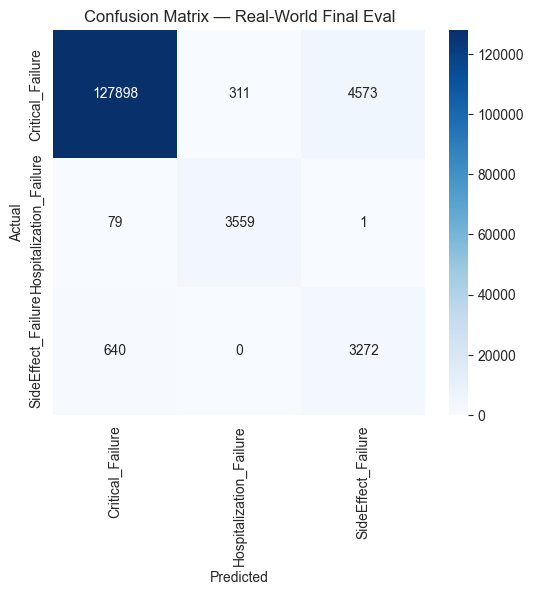

In [52]:
# Cell 8 — Evaluate

acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="macro")

print("\nFINAL REAL-WORLD EVALUATION")
print(f"Accuracy: {acc:.4f}")
print(f"F1-macro: {f1:.4f}\n")

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix — Real-World Final Eval")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [53]:
# Cell 9 — Save outputs

df["predicted_label"] = label_encoder.inverse_transform(y_pred)

out_path = os.path.join(BASE_DIR, "results", "final_evaluation_predictions.csv")
df.to_csv(out_path, index=False)

print("Saved →", out_path)


Saved → D:\ML_Project\results\final_evaluation_predictions.csv
